In [1]:
# Import python tools
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# old clip
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# # Import Secure Variable Tools from config.py ((IF NEEDED))
# from config import user
# from config import password
# from config import port

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# Path to sqlite
database_path = "Resources/hawaii.sqlite"

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

# Reflect Tables into SQLAlchemy ORM

In [6]:
# reflect an existing database into a new model
Base = automap_base()

In [7]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# View the tables another way just for practice
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Save references to each table as variable
mea = Base.classes.measurement
sta = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Take a peek at the data
engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
# get the column names and dtypes for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# Find the most recent date in the data set,
# & pass it into a variable.
most_recent_date = session.query(mea.date).order_by(mea.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date

'2017-08-23'

### Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [16]:
# Starting from the most recent data point in the database,
# Calculate the date one year from the last date in data set,
# Perform a query to retrieve the dates and precipitation values,
# & Save the query results, sorted by date, as a variable
pastyear_df = session.query(mea.date, mea.prcp).filter(mea.date > '2016-08-22').order_by(mea.date).all()
pastyear_df

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

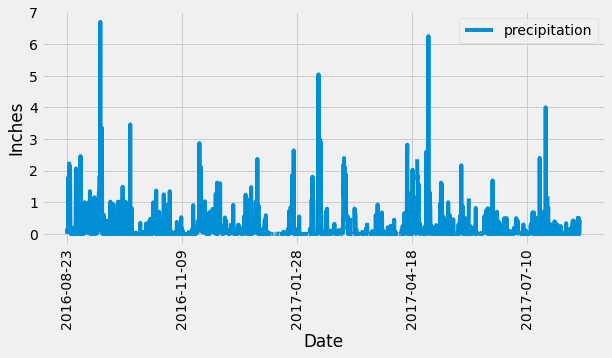

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
df = pd.DataFrame(pastyear_df, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)
df.plot(figsize=(9, 4))
plt.xlabel ("Date")
plt.ylabel ("Inches")
plt.xticks (rotation="vertical")
plt.savefig("Resources/Precipitation.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pastyear_df = pd.DataFrame(session.query(mea.date, mea.prcp).filter(mea.date > '2016-08-22').order_by(mea.date))
pastyear_df = pastyear_df.set_index('date')
pastyear_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

# <span style="color: blue;">CURRENTLY</span> <span style="color: green;">WORKING</span> <span style="color: red;">HERE</span>

In [23]:
# Take a peek at the data
engine.execute('select * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [20]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [29]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(sta.station, func.count(sta.station))[0][1]
station_count

9

In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()